In [5]:
!pip install imbalanced-learn
!pip install scikit-learn


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.svm import SVC
from sklearn.model_selection import KFold, cross_val_predict
from sklearn.naive_bayes import MultinomialNB



In [7]:
# Load your data
train_file = '/content/drive/MyDrive/Khai phá dữ liệu /filtered_dataset.txt'
test_file = '/content/drive/MyDrive/Khai phá dữ liệu /1agedetector_group_test.v1.0.txt'

def load_data(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()

    data = []
    for line in lines:
        tokens = line.strip().split(' ')
        data.append(tokens)

    return pd.DataFrame(data)

train_data = load_data(train_file)
test_data = load_data(test_file)

# Renaming the first column to 'label'
train_data.rename(columns={0: 'label'}, inplace=True)
test_data.rename(columns={0: 'label'}, inplace=True)


In [8]:
train_data.head()

,label,1,2,3,4,5,6,7,8,9,...,179,180,181,182,183,184,185,186,187,188
0,__label__18-24,1917715178553519,567730009909070,582021525162588,257477587601235,850172971724117,201218173578258,1612673425674520,125003007575271,934531709901246,...,None,None,None,None,None,None,None,None,None,None
1,__label__55+,1549131271824144,544900528944370,812273192241397,1700819020177228,962829697138623,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,__label__18-24,708982919265866,1691719041155281,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,__label__55+,207189973202782,236035250274969,174343750030391,2041493616081649,156400418235672,719056401608684,986410741490165,638502246257630,None,...,None,None,None,None,None,None,None,None,None,None
4,__label__45-54,721926094625837,1868157670136246,1606679136294164,658385127587544,155916111262380,317641925091560,1559154204351486,265578100290310,1439674156275508,...,None,None,None,None,None,None,None,None,None,None


In [9]:
# Label encoding
le = LabelEncoder()
train_data['label'] = le.fit_transform(train_data['label'])
test_data['label'] = le.transform(test_data['label'])

# Extract features and labels
X_train = train_data.iloc[:, 1:].fillna('').astype(str).values
y_train = train_data['label']
X_test = test_data.iloc[:, 1:].fillna('').astype(str).values
y_test = test_data['label']

# Use CountVectorizer to convert group_ids into binary features
vectorizer = CountVectorizer(tokenizer=lambda x: x.split())
X_train_vec = vectorizer.fit_transform([' '.join(row) for row in X_train])
X_test_vec = vectorizer.transform([' '.join(row) for row in X_test])



/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [10]:
# Print class distribution before resampling
print("Class distribution before resampling:")
print(Counter(y_train))


Class distribution before resampling:
Counter({0: 8379, 1: 6709, 3: 6288, 2: 5757, 4: 2455})


In [11]:
# Calculate mean class count
class_counts = Counter(y_train)
mean_class_count = int(np.mean(list(class_counts.values())))

# Random oversampling for the less represented class
ros = RandomOverSampler(sampling_strategy={4: mean_class_count})
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_vec, y_train)

# Random undersampling for the more represented classes
rus = RandomUnderSampler(sampling_strategy={k: mean_class_count for k in class_counts if class_counts[k] > mean_class_count})
X_train_resampled, y_train_resampled = rus.fit_resample(X_train_resampled, y_train_resampled)


In [12]:
# Print class distribution after resampling
print("Class distribution after resampling:")
print(Counter(y_train_resampled))

Class distribution after resampling:
Counter({0: 5917, 1: 5917, 3: 5917, 4: 5917, 2: 5757})


In [13]:
# Define a ruleset for group IDs and their associated age groups
ruleset = {
    '1173636692750000': 0,
    '455014721290845': 4,
    '659031707581980': 4,
}

def apply_ruleset(group_ids, ruleset):
    for group_id in group_ids:
        if group_id in ruleset:
            return ruleset[group_id]
    return None


In [14]:
X_train_vec.shape

(29588, 75926)

In [15]:
# Function to calculate nearest neighbor accuracy
def nearest_neighbor_accuracy(y_true, y_pred):
    correct = sum(1 for true, pred in zip(y_true, y_pred) if abs(true - pred) <= 1)
    return correct / len(y_true)

In [16]:
# Perform k-fold cross-validation
kf = KFold(n_splits=5)
log_reg = LogisticRegression(class_weight={0: 0.706, 1: 0.882, 2: 0.941, 3: 1.028, 4: 2.41}, max_iter=500)

# Collecting predictions and actual values for error analysis
y_pred_cv = cross_val_predict(log_reg, X_train_vec, y_train, cv=kf)

# Evaluate cross-validated predictions
print("Cross-validated Classification Report:")
print(classification_report(y_train, y_pred_cv, target_names=le.classes_))

Cross-validated Classification Report:
                precision    recall  f1-score   support

__label__18-24       0.81      0.70      0.75      8379
__label__25-34       0.60      0.52      0.55      6709
__label__35-44       0.51      0.42      0.46      5757
__label__45-54       0.44      0.63      0.52      6288
  __label__55+       0.30      0.34      0.32      2455

      accuracy                           0.56     29588
     macro avg       0.53      0.52      0.52     29588
  weighted avg       0.58      0.56      0.57     29588



In [17]:
log_reg.fit(X_train_vec, y_train)


LogisticRegression(class_weight={0: 0.706, 1: 0.882, 2: 0.941, 3: 1.028,
                                 4: 2.41},
                   max_iter=500)

In [18]:
# Evaluate the logistic regression model
y_pred_log_reg = log_reg.predict(X_test_vec)
target_names = le.inverse_transform([0, 1, 2, 3, 4]).astype(str)
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_log_reg, target_names=target_names))
log_reg_nn_accuracy = nearest_neighbor_accuracy(y_test, y_pred_log_reg)
print(f"Logistic Regression Nearest Neighbor Accuracy: {log_reg_nn_accuracy:.2f}")

Logistic Regression Classification Report:
                precision    recall  f1-score   support

__label__18-24       0.81      0.67      0.74      3801
__label__25-34       0.62      0.48      0.54      3176
__label__35-44       0.52      0.41      0.46      2671
__label__45-54       0.41      0.66      0.51      2990
  __label__55+       0.28      0.30      0.29      1130

      accuracy                           0.55     13768
     macro avg       0.53      0.51      0.51     13768
  weighted avg       0.58      0.55      0.55     13768

Logistic Regression Nearest Neighbor Accuracy: 0.81


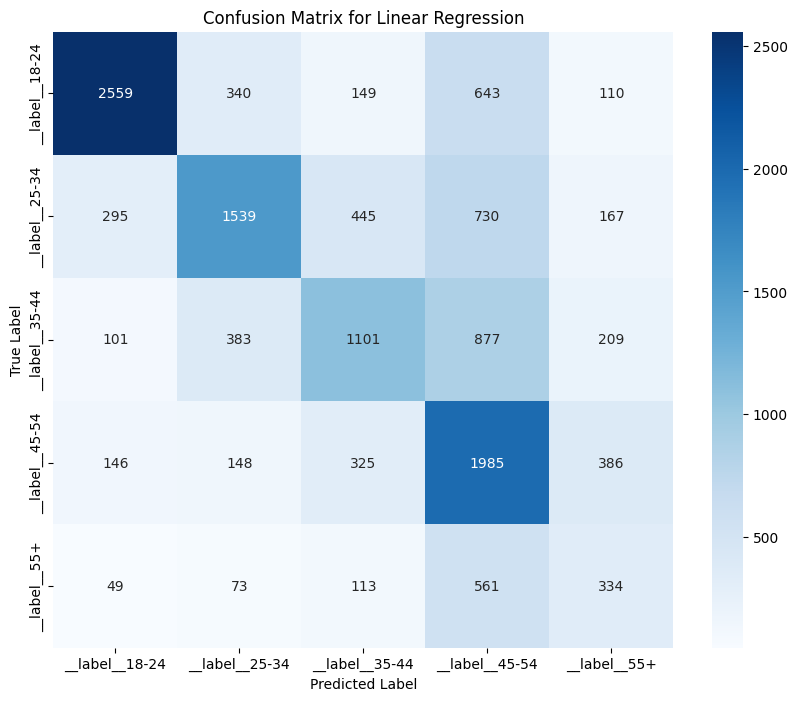

In [19]:
# Predict the labels
y_pred = log_reg.predict(X_test_vec)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Linear Regression')
plt.show()


In [20]:
# Perform k-fold cross-validation for Naive Bayes
nb = MultinomialNB()

# Collecting predictions and actual values for error analysis
y_pred_cv_nb = cross_val_predict(nb, X_train_vec, y_train, cv=kf)

# Evaluate cross-validated predictions for Naive Bayes
print("Cross-validated Classification Report for Naive Bayes:")
print(classification_report(y_train, y_pred_cv_nb, target_names=le.classes_))

# Train final Naive Bayes model on the entire resampled dataset
nb.fit(X_train_resampled, y_train_resampled)

# Evaluate the Naive Bayes model on the test dataset
y_pred_test_nb = nb.predict(X_test_vec)


Cross-validated Classification Report for Naive Bayes:
                precision    recall  f1-score   support

__label__18-24       0.68      0.85      0.76      8379
__label__25-34       0.56      0.54      0.55      6709
__label__35-44       0.49      0.44      0.46      5757
__label__45-54       0.54      0.58      0.56      6288
  __label__55+       0.34      0.11      0.16      2455

      accuracy                           0.58     29588
     macro avg       0.52      0.50      0.50     29588
  weighted avg       0.56      0.58      0.56     29588



Test Classification Report for Naive Bayes:
                precision    recall  f1-score   support

__label__18-24       0.60      0.83      0.70      3801
__label__25-34       0.59      0.52      0.55      3176
__label__35-44       0.48      0.44      0.46      2671
__label__45-54       0.57      0.42      0.49      2990
  __label__55+       0.30      0.26      0.28      1130

      accuracy                           0.55     13768
     macro avg       0.51      0.50      0.50     13768
  weighted avg       0.54      0.55      0.54     13768

Nearest Neighbor Accuracy on Test Set for Naive Bayes: 0.82


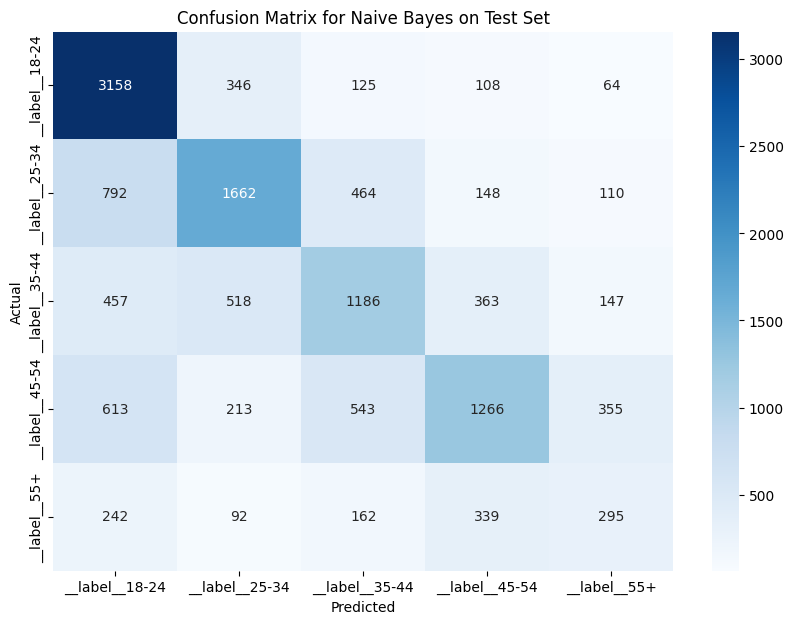

In [21]:
print("Test Classification Report for Naive Bayes:")
print(classification_report(y_test, y_pred_test_nb, target_names=le.classes_))
nn_accuracy_nb = nearest_neighbor_accuracy(y_test, y_pred_test_nb)
print(f"Nearest Neighbor Accuracy on Test Set for Naive Bayes: {nn_accuracy_nb:.2f}")

# Plot confusion matrix for the Naive Bayes test set
conf_mat_test_nb = confusion_matrix(y_test, y_pred_test_nb)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_test_nb, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for Naive Bayes on Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [22]:
# Train SVM model
svm = SVC(class_weight={0: 0.706, 1: 0.882, 2: 0.941, 3: 1.028, 4: 2.41}, kernel='linear')

y_pred_svm = cross_val_predict(svm, X_train_vec, y_train, cv=kf)

# Evaluate cross-validated predictions for Naive Bayes
print("Cross-validated Classification Report for SVM:")
print(classification_report(y_train, y_pred_svm, target_names=le.classes_))


Cross-validated Classification Report for SVM:
                precision    recall  f1-score   support

__label__18-24       0.74      0.66      0.70      8379
__label__25-34       0.54      0.46      0.49      6709
__label__35-44       0.46      0.39      0.42      5757
__label__45-54       0.41      0.60      0.49      6288
  __label__55+       0.27      0.27      0.27      2455

      accuracy                           0.52     29588
     macro avg       0.49      0.48      0.48     29588
  weighted avg       0.53      0.52      0.52     29588



In [23]:
svm.fit(X_train_vec, y_train)

y_pred_test_svm = svm.predict(X_test_vec)

Test Classification Report for SVM:
                precision    recall  f1-score   support

__label__18-24       0.76      0.64      0.70      3801
__label__25-34       0.56      0.44      0.49      3176
__label__35-44       0.47      0.39      0.42      2671
__label__45-54       0.40      0.63      0.49      2990
  __label__55+       0.27      0.25      0.26      1130

      accuracy                           0.51     13768
     macro avg       0.49      0.47      0.47     13768
  weighted avg       0.54      0.51      0.52     13768

Nearest Neighbor Accuracy on Test Set for SVM: 0.79


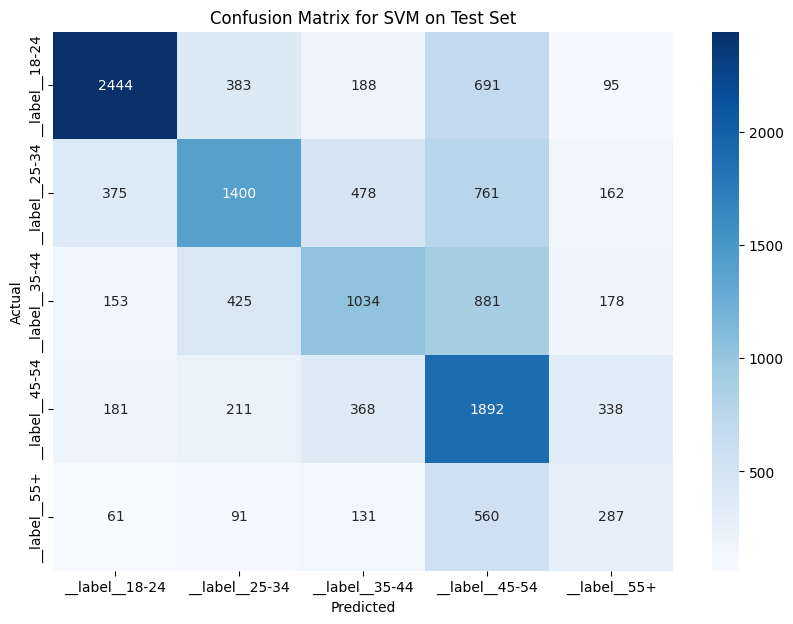

In [24]:
print("Test Classification Report for SVM:")
print(classification_report(y_test, y_pred_test_svm, target_names=le.classes_))
nn_accuracy_svm = nearest_neighbor_accuracy(y_test, y_pred_test_svm)
print(f"Nearest Neighbor Accuracy on Test Set for SVM: {nn_accuracy_svm:.2f}")

# Plot confusion matrix for the Naive Bayes test set
conf_mat_test_svm = confusion_matrix(y_test, y_pred_test_svm)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_test_svm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix for SVM on Test Set')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Logistic Regression with Ruleset Classification Report:
                precision    recall  f1-score   support

__label__18-24       0.80      0.67      0.73      3801
__label__25-34       0.62      0.48      0.54      3176
__label__35-44       0.51      0.41      0.46      2671
__label__45-54       0.41      0.65      0.50      2990
  __label__55+       0.27      0.31      0.29      1130

      accuracy                           0.54     13768
     macro avg       0.52      0.50      0.50     13768
  weighted avg       0.58      0.54      0.55     13768

Logistic Regression with Ruleset Nearest Neighbor Accuracy: 0.81


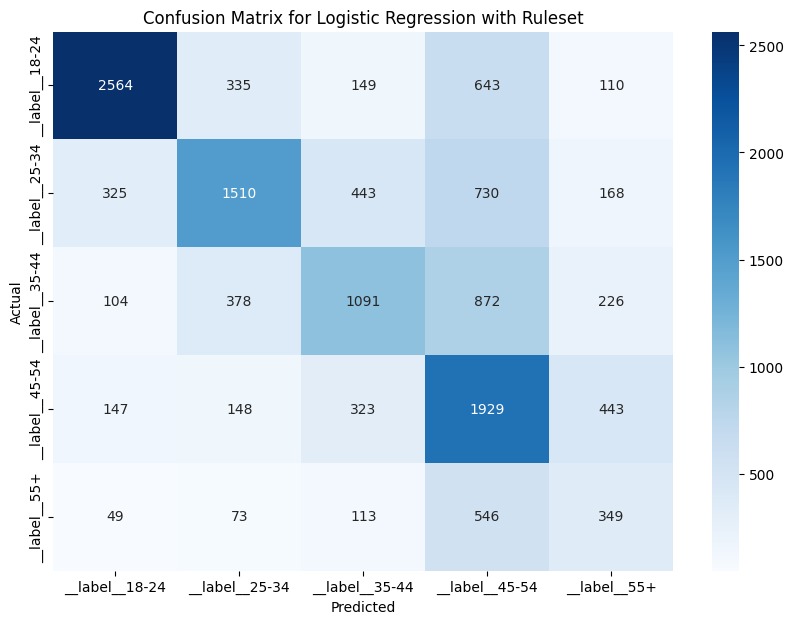

In [26]:
# Predict with ruleset and models for Logistic Regression
y_pred_ruleset_log_reg = [apply_ruleset(row, ruleset) for row in X_test]

# Predict remaining instances using the Logistic Regression model
remaining_indices_log_reg = [i for i, pred in enumerate(y_pred_ruleset_log_reg) if pred is None]
X_test_remaining_log_reg = X_test_vec[remaining_indices_log_reg]
y_test_remaining_log_reg = y_test[remaining_indices_log_reg]
y_pred_remaining_log_reg = log_reg.predict(X_test_remaining_log_reg)
for i, idx in enumerate(remaining_indices_log_reg):
    y_pred_ruleset_log_reg[idx] = y_pred_remaining_log_reg[i]

# Evaluate the Logistic Regression model with nearest neighbor accuracy
target_names = le.inverse_transform([0, 1, 2, 3, 4]).astype(str)
print("Logistic Regression with Ruleset Classification Report:")
print(classification_report(y_test, y_pred_ruleset_log_reg, target_names=target_names))
log_reg_nn_accuracy = nearest_neighbor_accuracy(y_test, y_pred_ruleset_log_reg)
print(f"Logistic Regression with Ruleset Nearest Neighbor Accuracy: {log_reg_nn_accuracy:.2f}")

# Plot confusion matrix for Logistic Regression with Ruleset
conf_mat_log_reg = confusion_matrix(y_test, y_pred_ruleset_log_reg)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_log_reg, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix for Logistic Regression with Ruleset')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Naive Bayes with Ruleset Classification Report:
                precision    recall  f1-score   support

__label__18-24       0.60      0.83      0.70      3801
__label__25-34       0.59      0.51      0.55      3176
__label__35-44       0.48      0.44      0.46      2671
__label__45-54       0.56      0.41      0.47      2990
  __label__55+       0.29      0.27      0.28      1130

      accuracy                           0.54     13768
     macro avg       0.50      0.49      0.49     13768
  weighted avg       0.54      0.54      0.53     13768

Naive Bayes with Ruleset Nearest Neighbor Accuracy: 0.82


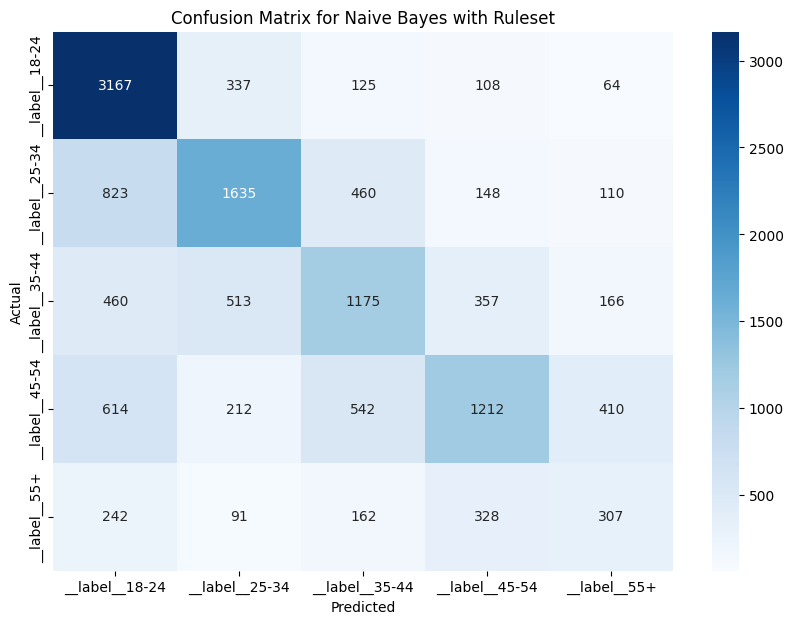

In [27]:
# Predict with ruleset and models for Naive Bayes
y_pred_ruleset_nb = [apply_ruleset(row, ruleset) for row in X_test]

# Predict remaining instances using the Naive Bayes model
remaining_indices_nb = [i for i, pred in enumerate(y_pred_ruleset_nb) if pred is None]
X_test_remaining_nb = X_test_vec[remaining_indices_nb]
y_test_remaining_nb = y_test[remaining_indices_nb]
y_pred_remaining_nb = nb.predict(X_test_remaining_nb)
for i, idx in enumerate(remaining_indices_nb):
    y_pred_ruleset_nb[idx] = y_pred_remaining_nb[i]

# Evaluate the Naive Bayes model with nearest neighbor accuracy
print("Naive Bayes with Ruleset Classification Report:")
print(classification_report(y_test, y_pred_ruleset_nb, target_names=target_names))
nb_nn_accuracy = nearest_neighbor_accuracy(y_test, y_pred_ruleset_nb)
print(f"Naive Bayes with Ruleset Nearest Neighbor Accuracy: {nb_nn_accuracy:.2f}")

# Plot confusion matrix for Naive Bayes with Ruleset
conf_mat_nb = confusion_matrix(y_test, y_pred_ruleset_nb)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_nb, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix for Naive Bayes with Ruleset')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

SVM with Ruleset Classification Report:
                precision    recall  f1-score   support

__label__18-24       0.75      0.65      0.69      3801
__label__25-34       0.55      0.43      0.49      3176
__label__35-44       0.47      0.38      0.42      2671
__label__45-54       0.39      0.62      0.48      2990
  __label__55+       0.26      0.26      0.26      1130

      accuracy                           0.51     13768
     macro avg       0.48      0.47      0.47     13768
  weighted avg       0.53      0.51      0.51     13768

SVM with Ruleset Nearest Neighbor Accuracy: 0.79


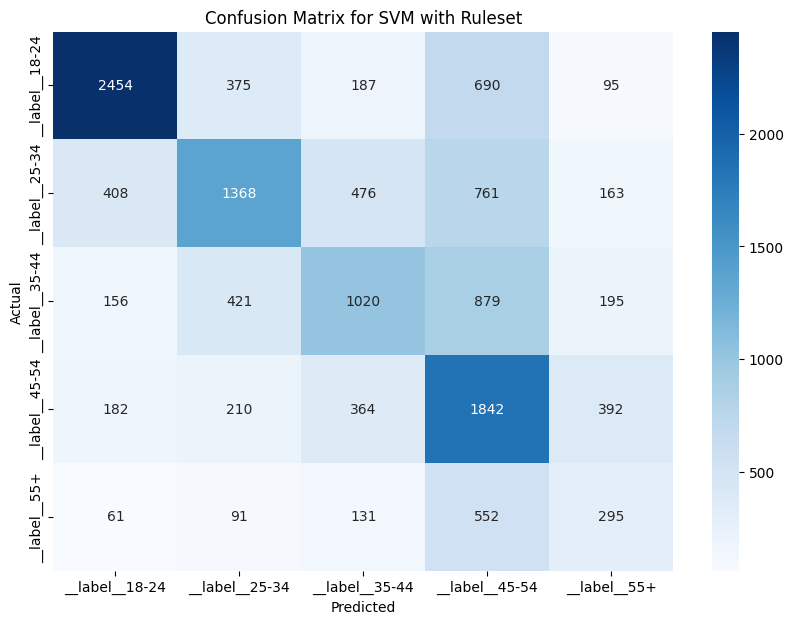

In [28]:
# Predict with ruleset and models for SVM
y_pred_ruleset_svm = [apply_ruleset(row, ruleset) for row in X_test]

# Predict remaining instances using the SVM model
remaining_indices_svm = [i for i, pred in enumerate(y_pred_ruleset_svm) if pred is None]
X_test_remaining_svm = X_test_vec[remaining_indices_svm]
y_test_remaining_svm = y_test[remaining_indices_svm]
y_pred_remaining_svm = svm.predict(X_test_remaining_svm)
for i, idx in enumerate(remaining_indices_svm):
    y_pred_ruleset_svm[idx] = y_pred_remaining_svm[i]

# Evaluate the SVM model with nearest neighbor accuracy
print("SVM with Ruleset Classification Report:")
print(classification_report(y_test, y_pred_ruleset_svm, target_names=target_names))
svm_nn_accuracy = nearest_neighbor_accuracy(y_test, y_pred_ruleset_svm)
print(f"SVM with Ruleset Nearest Neighbor Accuracy: {svm_nn_accuracy:.2f}")

# Plot confusion matrix for SVM with Ruleset
conf_mat_svm = confusion_matrix(y_test, y_pred_ruleset_svm)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_mat_svm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Confusion Matrix for SVM with Ruleset')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()